<a href="https://colab.research.google.com/github/dzurel/Fellowship.ai/blob/master/FastAIChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing necessary packages

In [0]:
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling, selection, and evaluation
from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder

%matplotlib inline 

I will use the proposed ULMFiT, an effective and extremely sample-efficient transfer learning method that can be applied to any NLP task. (Jeremy Howard, Sebastian Ruder. 2018. Universal Language Model Fine-tuning for Text Classification) ULMFiT describes a way to train all layers, and does so without overfitting or running into “catastropic forgetting”, which has been more of a problem for NLP. There is a “semi-supervised” mothod which means that the model was fine-tuned on unlabeled in-domain data. ULMFiT has revolutionized the field of transfer learning in NLP by using language modelling during pre-training, which has significantly improved on the state-of-the-art for a variety of tasks in natural language understanding. ULMFit uses its own pretrained language model wikitext-103 that can be conveniently downloaded from the fastai database hosted on AWS.

### Data Preparation and Exploration

In [2]:
# Reading the CSV file into dataframe
df = pd.read_csv("https://raw.githubusercontent.com/dzurel/Fellowship.ai/master/Tweets.csv")
df = df.reindex(np.random.permutation(df.index))  
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
5774,568614676612964352,positive,1.0000,NaN,NaN,Southwest,NaN,THlSICKBEAT,NaN,0,@SouthwestAir Hi! I ❤️ your company and fly al...,NaN,2015-02-19 19:34:37 -0800,NaN,NaN
6879,570066554848743424,negative,1.0000,Late Flight,1.0000,Delta,NaN,djcheros,NaN,0,@JetBlue we would have been up in the air by n...,NaN,2015-02-23 19:43:52 -0800,"Portland, Maine",Eastern Time (US & Canada)
6088,568262925833515008,neutral,0.6479,NaN,NaN,Southwest,NaN,NuEarRich,NaN,0,@SouthwestAir inflight entertainment. Tonight...,NaN,2015-02-18 20:16:53 -0800,"Phoenix, AZ",NaN
289,568850943359496192,negative,1.0000,Bad Flight,0.6979,Virgin America,NaN,AdamSinger,NaN,0,@VirginAmerica soooo are you guys going to lea...,"[0.0, 0.0]",2015-02-20 11:13:28 -0800,"San Francisco, CA",Central Time (US & Canada)
9771,569672234949742592,negative,0.6670,Flight Attendant Complaints,0.3485,US Airways,NaN,weezerandburnie,NaN,0,@USAirways Really a letter that says you will ...,NaN,2015-02-22 17:36:59 -0800,Belle MO,NaN


airline_sentiment is the dependent variable. Let's check it's distribution.

[]

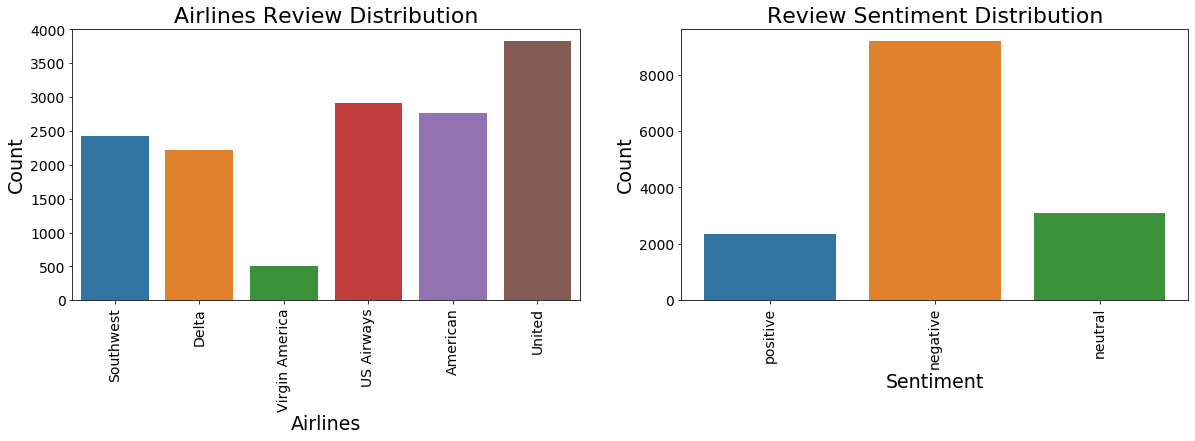

In [3]:
figsize=(20, 5)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

plt.subplot(121)
col = "airline"
xlabel = "Airlines"
ylabel = "Count"

sns.countplot(x=df[col])
plt.title("Airlines Review Distribution")
plt.xticks(rotation=90)
plt.xlabel(xlabel)
plt.ylabel(ylabel)


plt.subplot(122)
col = "airline_sentiment"
xlabel = "Sentiment"
ylabel = "Count"
sns.countplot(df[col])
plt.title("Review Sentiment Distribution")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=90)
plt.plot()

Checking the airline companies. Most of the reviews are negative.
Highest number of tweets are about "United Airlines", "US Airlines" and "American Airlines"

Grouping the airline companies and sentiments

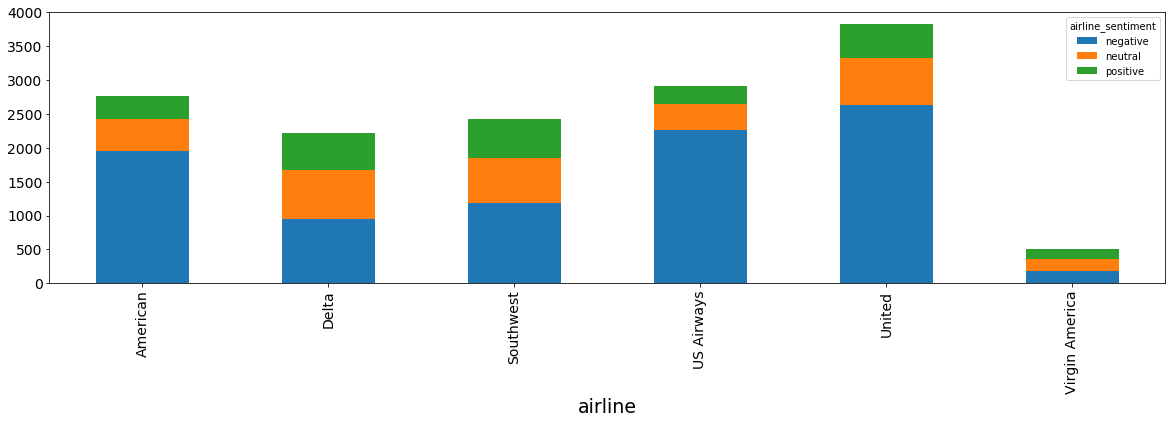

In [4]:
df.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar', stacked=True)

Virgin America seems to have more balanced tweets than others.

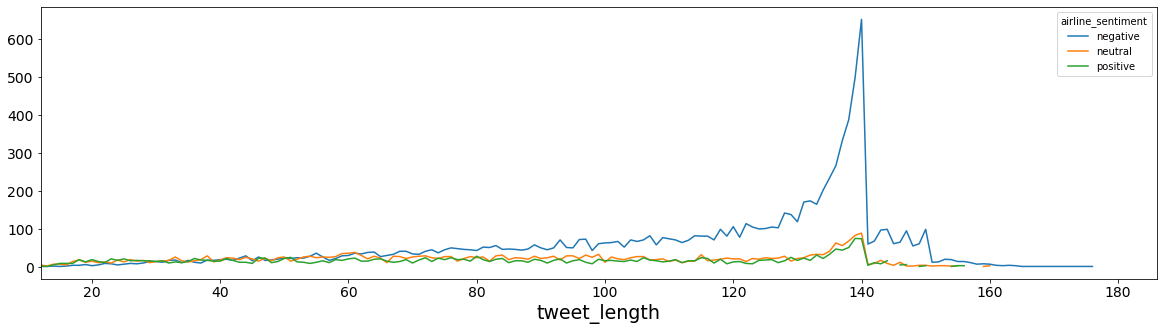

In [5]:
df['tweet_length'] = df['text'].apply(len)
df.groupby(['tweet_length', 'airline_sentiment']).size().unstack().plot(kind='line', stacked=False)

When people have negative tweets like complains, the tweet length is increasing. 
We see that there isn't a lot of correlation between the number of positive / neutral tweets and the tweet length, but for negative tweets the distribution is heavily skewed towards longer tweets. This is possibly because the angry people have a lot to say. Next we'll see if the same observation can be made about the average and median sentiment confidence as well.

[]

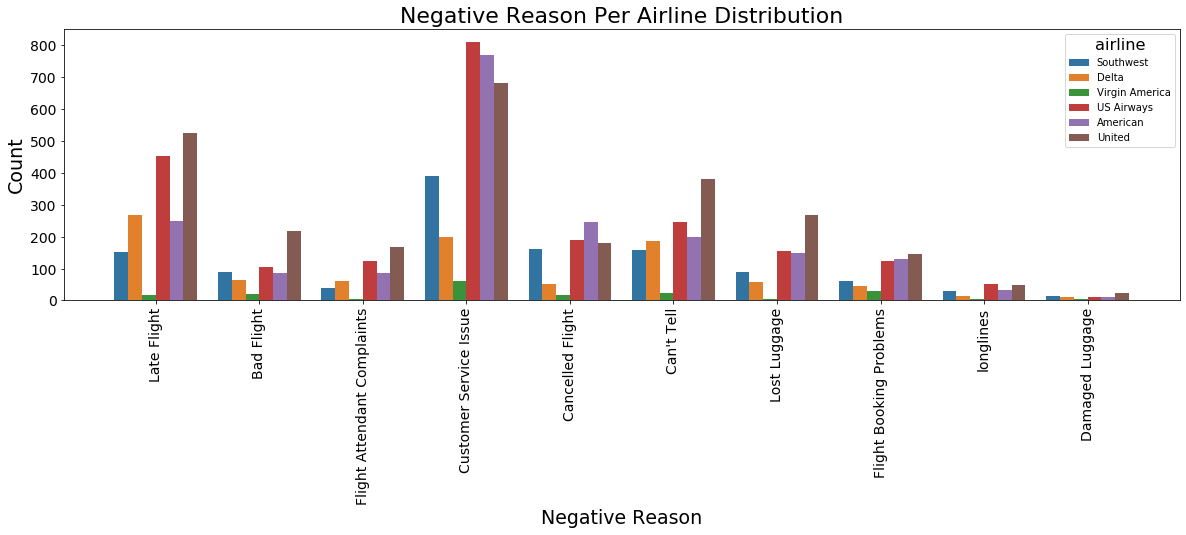

In [6]:
figsize=(20, 5)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

xlabel = "Negative Reason"
ylabel = "Count"

title = "Negative Reason Per Airline Distribution"


params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

col1 = "negativereason"
col2 = "airline"
sns.countplot(x=df[col1], hue=df[col2])
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=90)
plt.plot()

Most of the negative tweets are about "Customer Service Issue" and then "Late Flight.
Next we randomize and split the data, then write to CSVs.

[]

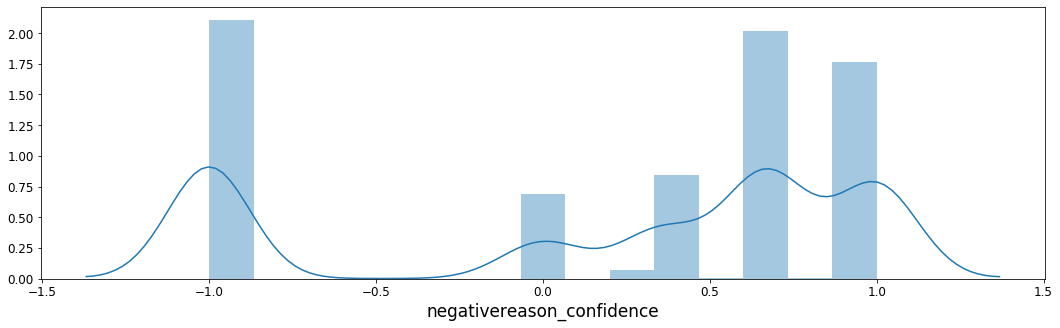

In [7]:
x = df["negativereason_confidence"].fillna(-1)

figsize=(18, 5)

ticksize = 12
titlesize = ticksize + 8
labelsize = ticksize + 5

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)
sns.distplot(x)
plt.plot()

In [0]:
test_percentage = 0.1
df.sort_index(inplace=True)
cutoff = int(test_percentage * df.shape[0])
df[['airline_sentiment', 'text']][:cutoff].to_csv('Filtered_tweets_test.csv', 
                                                  index=False, encoding='utf-8')
df[['airline_sentiment', 'text']][cutoff:].to_csv('Filtered_tweets_train.csv', 
                                                  index=False, encoding='utf-8')
df[['text']][cutoff:].to_csv('Tweets_text_only_train.csv', index=False, encoding='utf-8')

In [0]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

In [45]:
df['text'] = df['text'].apply(clean_ascii)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,tweet_length
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),35
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),72
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),71
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),126
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),55


### Tokenization

We read in the data and add new words to our dictionary, as well as create a representation of words using numbers.

In [11]:
data = TextClasDataBunch.from_csv('.', 'Filtered_tweets_train.csv')
data.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @united xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup san68059 m,negative
xxbos @americanair xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to chnge it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
"xxbos @united xxmaj united xxmaj club team is xxup a+ & & got me a seat xxmaj late xxmaj flightr . xxmaj still , not sure why a last min xxup ual xxmaj cancelled xxmaj flightlation costs me $ yet overbooked folks get $ ?",negative
"xxbos xxup @usairways xxup are xxup you xxup kidding xxup me ? ? xxmaj bad customer service , folks . xxmaj flew from xxup psp to xxup phx flight xxunk on 2 / 19 . ( cont ) http : / / t.co / xxunk",negative


The following changes have been made to the text for ease of modeling:

- split on space and punctuation symbols
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below)

In [12]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

Looking into the dataset we can now see the current representation post-processing, in both text form and numerical.

In [13]:
print(data.train_ds[0][0])
print(data.train_ds[1][0])
print(data.train_ds[2][0])

xxbos @usairways xxmaj no , they wo n't because after 5 hours of holding i had to give up because i could n't xxunk the phone any longer . 5 hours ...
xxbos @southwestair been on hold for an hour . i need to rebook my flight that was xxmaj cancelled xxmaj flighted ! # help
xxbos @americanair xxmaj thanks to xxup aa for the upgrade today and getting me on a new flight after my first one was xxmaj cancelled xxmaj flightled !


In [14]:
print(data.train_ds[0][0].data[:10])
print(data.train_ds[1][0].data[:10])
print(data.train_ds[2][0].data[:10])

[  2  24   5  42  18  73 230  34 151 115]
[  2  29  69  21  81  19  63 113   9  11]
[  2  25   5  59  10   6 207  19  12 390]


### Language Model

We'll be using a language model provided from the fastai library. This will provide a word embedding scheme that aligns with the corpus of airline tweets and will hopefully capture sufficient "meaning" in each word. The language model here will not be optimal as tweets sometimes do not obey conventional spelling and grammar, especially hastags.



In [0]:
bs = 24
seed = 333

First we ingest the data once again but have a 10% holdout only since we'll be using it to calibrate the language model.


In [16]:
data_lm = (TextList.from_csv('.', 'Tweets_text_only_train.csv')
            .random_split_by_pct(0.1, seed = seed)
           #We randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [17]:
# data_lm = load_data(path, 'data_lm.pkl', bs=bs)
data_lm.show_batch()

idx,text
0,xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj xxunk ) tomorrow xxbos @united xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you xxbos @united it was delivered ! xxmaj thank you for making sure it arrived at my xxunk ! xxbos @united - rebooked
1,"good to know . xxbos @united okay . xxmaj thanks . xxbos @united xxmaj conference xxunk in 3 hours . xxmaj up all night due to delays and still waiting to talk to someone about lost luggage . xxbos @united xxmaj seat xxup xxunk , xxmaj flight xxup xxunk xxbos @united is it on a flight now ? xxmaj thanks for reply . xxbos @united is xxunk and i am"
2,"and the delay turns into a xxmaj cancelled xxmaj flight ... xxbos @united xxup ua xxunk delayed again - i get charged $ 600 if xxmaj late xxmaj flight by you - you say "" oh well "" xxbos @united we are trying to go as far away from king'scollegelondon as possible for # charity today . xxmaj would you help us ? # jailbreak # xxup rag xxbos @united"
3,"back to 1st class . xxmaj xxunk ? xxmaj really ? @united : xxunk xxmaj your xxunk is xxunk xxbos @united xxmaj thanks xxmaj yup i 'm all set . xxmaj it happens . xxup slc ground staff were prompt , helpful and courteous . xxbos xxmaj there were plenty of empty seats in coach "" @united : xxmaj your xxunk is understood . xxmaj crew members traveling for duty"
4,"when i boarded . xxbos “ @united : xxunk xxmaj sorry to hear about your flight . xxmaj do you need help reflight xxmaj booking xxmaj problems ? ” \n \n 👎 xxbos @united now we are trying to get to xxmaj san xxmaj juan from xxmaj chicago o'hare . xxmaj having lots of problems . xxmaj may get a standby flight . xxbos @united xxmaj alright , thank"


### **Running the language_model_learner class**
Next we fit the model for a few cycles by running 1 epoch and then unfreezing and running more epochs to fine tune. 
The pre-trained language model quickly downloads from the fastai's AWS link, so there is no need to download it separately. As per the ULMFit paper, we use a custom dropout for each language model layer, and the drop_multjust scales a numpy array of these dropouts which remain in the same relative ratio to one another. These numbers have been obtained through empirical tuning for a range of language tasks, and we took note of this during our extensive reading on this task.

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [19]:
learn.lr_find(start_lr=1e-7, end_lr=1e2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 8.71E-02
Min loss divided by 10: 4.57E-02


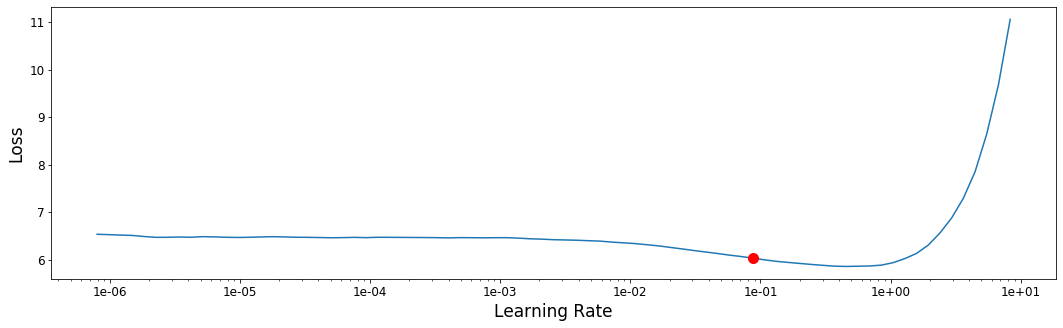

In [20]:
learn.recorder.plot(suggestion=True)

Next we fit the model for a few cycles by running 1 epoch and then unfreezing and running more epochs to fine tune.



In [21]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.102157,3.805691,0.267351,00:14


In [0]:
learn.save('fit_head')
# learn.load('fit_head')

In [0]:
learn.unfreeze()

### Unfreeze the entire model
Like a computer vision model, we can then unfreeze the model and fine-tune it. To train the language model during fine-tuning, we unfreeze all the layers and then perform training for a reasonable time until we obtain a low enough validation loss. For a larger target vocabulary, these hyperparameters might need to be modified, and the training time would be significantly longer. The first phase — unsupervised pre-training — is expensive and slow, but only has to happen once. Selecting cyc_len=10 for a faster examination.

Note: Tried cyc_len = 20 a few times and I am sure that it was overfitting. No acuracy gain, training loss kept lowering while valid_loss kept increasing.

In [24]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.712030,3.666821,0.286905,00:20
1,3.581939,3.578610,0.296905,00:19
2,3.408933,3.525737,0.303006,00:19
3,3.129626,3.523332,0.304851,00:19
4,2.782089,3.598218,0.302619,00:19
5,2.414582,3.704553,0.297262,00:19
6,2.089364,3.842652,0.292381,00:19
7,1.837339,3.921784,0.292054,00:19
8,1.684617,3.986367,0.290565,00:19
9,1.609947,4.007982,0.290179,00:19


In [0]:
learn.save('fine_tuned')


In [0]:
learn.save_encoder('fine_tuned_enc')

Tweets dont always follow proper English spelling and grammar, making it difficult for the model to correctly predict.

### Building a Classifier

We now use the data_clas object we created earlier to build a classifier with our fine-tuned encoder. The learner object can be done in a single line. We'll use the encoder from the language model in our classifier, which has a similar LSTM architecture but will predict the sentiment instead of the next word in a tweet. The model architecture here presents some advantages over traditional bags-of-words



In [27]:
data_clas = (TextList.from_csv('.', 'Filtered_tweets_train.csv', cols = 'text')               
             .split_by_rand_pct(0.1, seed = seed)
             .label_from_df(cols=0)
             .databunch(bs=bs))
data_clas.save('data_clas.pkl')
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @americanair xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to xxunk it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
xxbos @usairways xxmaj my xxmaj flight xxmaj booking xxmaj problems xxup xxunk just times out when i select it under xxmaj manage xxmaj my xxmaj flight xxmaj booking xxmaj problems for months now . i have emailed but no response . xxmaj help ?,negative
"xxbos @united ( 2 / 2 ) xxmaj it xxunk that if ca n't confirm xxunk at time of xxmaj flight xxmaj booking xxmaj problems , i should assume that it may never clear . xxmaj did n't used to be that way",negative
xxbos @united xxmaj missed xxup xxunk flight due to ur xxmaj cancelled xxmaj flightlation . xxmaj xxunk supervisor disgusting . xxmaj now day xxmaj late xxmaj flight . xxmaj no apology or upgrade offer to xxup lhr from xxup ord ? ? ?,negative


In [28]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11859 items)
x: TextList
xxbos @united the delay is due to customer service for 20 people ? xxmaj what about the xxup xxunk - xxup service you provided for 100 + ? # xxunk # xxunk,xxbos @united he is so excellent and so reliable :) # happycustomer,xxbos @united but again xxup united xxup xxunk xxup give 2 xxup xxunk xxup about xxup their xxup customers,xxbos @united xxmaj she is travelling from xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj xxunk ) tomorrow,xxbos @united xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you
y: CategoryList
negative,positive,negative,neutral,neutral
Path: .;

Valid: LabelList (1317 items)
x: TextList
xxbos @usairways stuck on xxmaj tarmac for 30 mins at xxup phl waiting for someone to load baggage , ridiculous http : / / t.co / xxunk,xxbos @southwestair i consider myself a loyal

In [29]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


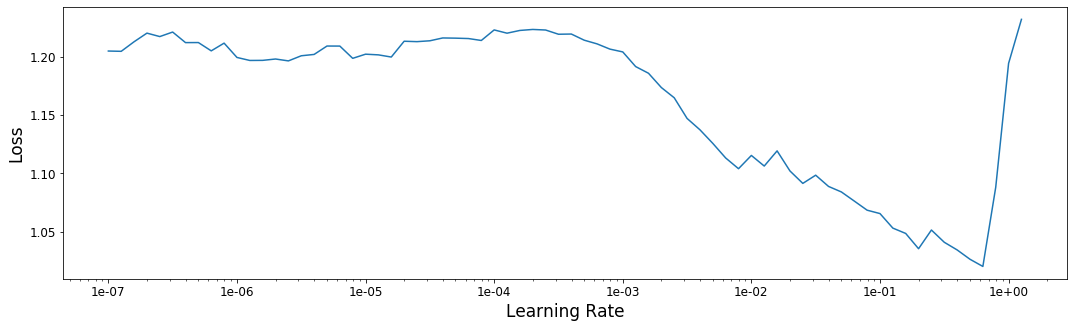

In [30]:
learn.recorder.plot(suggestion=True)

We train by gradually unfreezing layers and then running an epoch each time, in accordance with the suggestions in the ULMFiT paper. (https://docs.fast.ai/text.html#Text-models,-data,-and-training)

In [31]:
lr = 2e-2
learn.fit_one_cycle(1, lr, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.684821,0.529561,0.790433,00:09


In [0]:
learn.save('first')
# learn.load('first)

In [33]:
learn.freeze_to(-2)
lr = 1e-2
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.635285,0.497954,0.801063,00:12


In [0]:
learn.save('second')
# learn.load('second')

In [35]:
learn.freeze_to(-3)
lr = 5e-3
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.543649,0.460496,0.824601,00:19


In [36]:
learn.unfreeze()
lr = 1e-3
learn.fit_one_cycle(5, slice(lr/(2.6**4),lr), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.463677,0.447472,0.825361,00:23
1,0.436120,0.472091,0.815490,00:24
2,0.379958,0.455030,0.821564,00:25
3,0.357571,0.469619,0.829157,00:25
4,0.293447,0.477078,0.826879,00:25


Again feels like overfitting after 5 cycle. I guess, I have to be happy with 83% accuracy here.

Evaluate Performance on Test Set


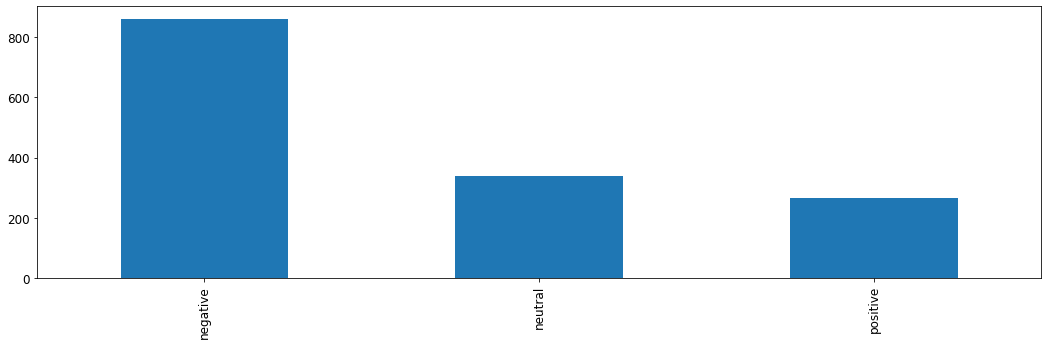

In [37]:
test_df = pd.read_csv("Filtered_tweets_test.csv", encoding="utf-8")
test_df['airline_sentiment'].value_counts().plot(kind='bar')

In [46]:
test_df['pred_sentiment'] = test_df['text'].apply(lambda row: str(learn.predict(row)[0]))
print("Test Accuracy: ", accuracy_score(test_df['airline_sentiment'], test_df['pred_sentiment']))

Test Accuracy:  0.8046448087431693


In [39]:
test_df[:20]

,airline_sentiment,text,pred_sentiment
0,neutral,@VirginAmerica What @dhepburn said.,neutral
1,positive,@VirginAmerica plus you've added commercials t...,negative
2,neutral,@VirginAmerica I didn't today... Must mean I n...,neutral
3,negative,@VirginAmerica it's really aggressive to blast...,negative
4,negative,@VirginAmerica and it's a really big bad thing...,negative
5,negative,@VirginAmerica seriously would pay $30 a fligh...,negative
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",negative
7,neutral,@VirginAmerica Really missed a prime opportuni...,negative
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D",neutral
9,positive,"@VirginAmerica it was amazing, and arrived an ...",positive


Plot confusion matrix to see where the areas of misclassification are.



In [0]:
# Confusion matrix plotting adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

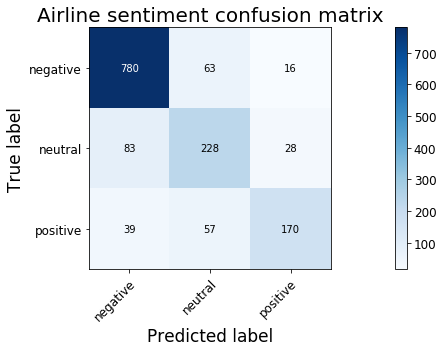

In [41]:
plot_confusion_matrix(test_df['airline_sentiment'], test_df['pred_sentiment'], classes=['negative', 'neutral', 'positive'], title='Airline sentiment confusion matrix')
# confusion_matrix(test_df['airline_sentiment'], test_df['pred_sentiment'], labels=['positive', 'neutral', 'negative'])
plt.show()

From the confusion matrix, we can see that within True Negatives, the prediction accuracy is pretty high. The model has a very hard time classifying neutral tweets, and often misclassifies them as negative. For True Positives, the overall accuracy is pretty good but a surprisingly large number get classified as negative. Let's look at these in closer detail:



In [42]:
test_df.loc[(test_df['airline_sentiment'] == 'positive') & (test_df['pred_sentiment'] == 'negative')]

,airline_sentiment,text,pred_sentiment
1,positive,@VirginAmerica plus you've added commercials t...,negative
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",negative
64,positive,@VirginAmerica @ladygaga @carrieunderwood lov...,negative
81,positive,@VirginAmerica I've applied more then once to ...,negative
114,positive,@VirginAmerica come back to #PHL already. We n...,negative
118,positive,@VirginAmerica your beautiful front-end design...,negative
273,positive,@VirginAmerica cutest salt and pepper shaker e...,negative
307,positive,@VirginAmerica I mean. Probably inappropriate ...,negative
323,positive,@VirginAmerica How about some free drinks on t...,negative
358,positive,@VirginAmerica just promoting the product is a...,negative


It's not immediately clear what the common thread that led these tweets to be mislabelled but possible causes include missing signals from hastags, non-grammatical sentences, mis-spellings, etc. which generally contribute to the classification error.

In the future, it would be good to spend more time on feature engineering and fitting the language model so that it's more suited to the vocabulary and style of language that is in tweets. From the language model and processing steps, we can see that the model accuracy is not very high and that, even as humans, it's hard to discern the sentiment from the post-processed / tokenized text. One possible way of addressing this issue is to use a much larger corpus of tweets when developing the language model.

In [0]:
from wordcloud import WordCloud,STOPWORDS

def generate_wordcloud(text, title): 
    wordcloud = WordCloud(relative_scaling = 1.0,stopwords = STOPWORDS, background_color='black').generate(text)
    fig,ax = plt.subplots(1,1,figsize=(14,18))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.margins(x=0, y=0)
    plt.title(title)
    plt.show()

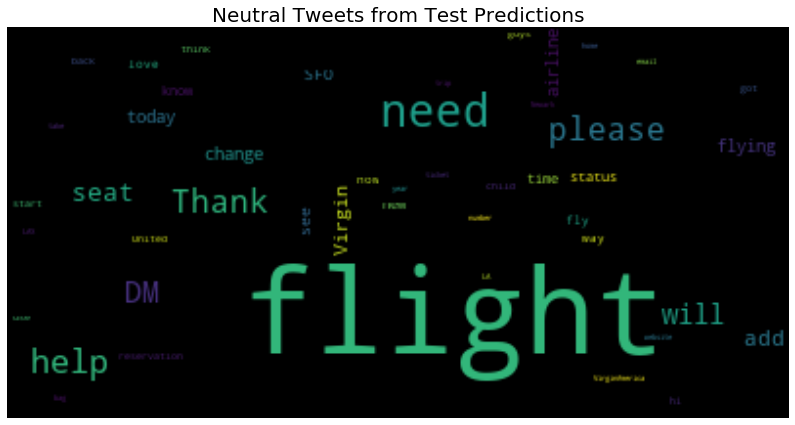

In [60]:
words_neutral = ' '.join(test_df[test_df['pred_sentiment']=='neutral']['text'])
cleaned_word_neutral = " ".join([word for word in words_neutral.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

generate_wordcloud(cleaned_word_neutral, 'Neutral Tweets from Test Predictions')